In [2]:
using DataFrames
using Query
using ProgressMeter
using PyPlot
using RCall

In [3]:
module FUND
    include("fund/src/marginaldamages.jl")
end
module RICE
    include("mimi-rice-2010.jl/src/marginaldamage.jl")
end

RICE

In [4]:
const rice_regions = ["US", "EU", "Japan", "Russia", "Eurasia", "China", "India", "MidEast", "Africa", "LatAm", "OHI", "OthAsia"]
const fund_regions = ["USA", "CAN", "WEU", "JPK", "ANZ", "EEU", "FSU", "MDE", "CAM", "LAM", "SAS", "SEA", "CHI", "NAF", "SSA", "SIS"];

Allocate some Dicts that hold the output per model. Key is model name

In [5]:
σ_squareds = Dict{String,Matrix{Float64}}()
cpcs = Dict{String,Matrix{Float64}}()
pops = Dict{String,Matrix{Float64}}()
globpops = Dict{String,Vector{Float64}}()
mds = Dict{String,Matrix{Float64}}()

Dict{String,Array{Float64,2}} with 0 entries

## Aggregate SSPs

In [7]:
R"""
source('aggregate_ssp.r')
""";

# FUND

In [8]:
# Price inflator from $1995 to $2014, taken from http://www.bls.gov/data/inflation_calculator.htm
const priceInflatorFUND = 1.55

1.55

## Get $\sigma^2$ for FUND

In [9]:
x1 = readcsv("../output/fund_sigmasquared_2010_2100.csv")
# Fix column/row layout
x2 = x1'
# Original uses a 5 year timestep, this repeats each year entry five times to get to a yearly matrix
x3 = repeat(x2, inner=[5,1])
# Create a matrix for later years that are not covered in the input file, by simply repeating the last year
x4 = repmat(x3[end,:]', 195, 1)
# Combine the matrix for the covered years with the matrix for the later years
x5 = vcat(x3, x4)
# Done
σ_squareds["FUND"] = x5[6:end,:];

## Run FUND

In [10]:
param_fund = FUND.loadparameters("fund/data");
m_fund = FUND.getfund(params=param_fund);
run(m_fund)
pops["FUND"] = m_fund[:population, :populationin1][65:65+284,:];
globpops["FUND"] = vec(sum(m_fund[:population, :populationin1], 2))[65:65+284]
cpcs["FUND"] = (m_fund[:socioeconomic, :consumption] ./ m_fund[:population, :populationin1])[65:65+284,:] .* priceInflatorFUND
mds["FUND"] = FUND.getmarginaldamages(parameters=param_fund, emissionyear=2015)[65:65+284,:].*12/44;

# RICE

In [11]:
# Price inflator from $2005 to $2014, taken from http://www.bls.gov/data/inflation_calculator.htm
const priceInflatorRICE = 1.21

1.21

## Get $\sigma^2$ for RICE

In [12]:
x1 = readcsv("../output/rice_sigmasquared_2010_2100.csv")
# Fix column/row layout
x2 = x1'
# Original uses a 5 year timestep, this repeats each year entry five times to get to a yearly matrix
x3 = repeat(x2, inner=[5,1])
# Create a matrix for later years that are not covered in the input file, by simply repeating the last year
x4 = repmat(x3[end,:]', 195, 1)
# Combine the matrix for the covered years with the matrix for the later years
x5 = vcat(x3, x4)
# Done
σ_squareds["RICE"] = x5[6:end,:];

## Run RICE

In [13]:
m_rice = RICE.getrice()
run(m_rice)

In [14]:
x2 = RICE.getmarginaldamages_rice(emissionyear=2015)[2:end,:]
# Original uses a 10 year timestep, this repeats each year entry ten times to get to a yearly matrix
x3 = repeat(x2, inner=[10,1])
# Leave out some later years to match σ_squared size
x4 = x3[1:285,:]
# Price level adjustment
x5 = x4 .* priceInflatorRICE
mds["RICE"] = x5.*12/44;

In [15]:
x2 = m_rice[:neteconomy, :CPC][2:end,:].*1000
# Original uses a 10 year timestep, this repeats each year entry ten times to get to a yearly matrix
x3 = repeat(x2, inner=[10,1])
# Leave out some later years to match σ_squared size
x4 = x3[1:285,:]
# Price level adjustment
x5 = x4 .* priceInflatorRICE
cpcs["RICE"] = x5;

In [16]:
x2 = m_rice[:grosseconomy, :l][2:end,:]
# Original uses a 10 year timestep, this repeats each year entry ten times to get to a yearly matrix
x3 = repeat(x2, inner=[10,1])
# Leave out some later years to match σ_squared size
x4 = x3[1:285,:]
pops["RICE"] = x4
globpops["RICE"] = vec(sum(x4, 2));

# Create inequality plots

In [17]:
writecsv("../output/RICE_cpc.csv", cpcs["RICE"])
writecsv("../output/FUND_cpc.csv", cpcs["FUND"])
writecsv("../output/RICE_pop.csv", pops["RICE"])
writecsv("../output/FUND_pop.csv", pops["FUND"]);

In [19]:
R"""
source('inequality_plots.r')
""";

# Compute SCC

Main equation of the paper

In [20]:
function equation11(cpc, pop, globpop, md, σsquared, σZero, γ, η, ρ, α, focus_region, I, c_ede)
    timesteps, regions = size(cpc)
    
    for t=1:timesteps, r=1:regions
        if σZero
            I[t, r] = 1.0 - exp(-0.5 * γ * 0.0)
        else
            I[t, r] = 1.0 - exp(-0.5 * γ * σsquared[t, r])
        end
    end
      
    for t=1:timesteps
        if γ == 1.
            # DOUBLE CHECK
            temp_x = 0.
            for r=1:regions
                temp_x += pop[t,r] * log(cpc[t,r] * (1.0 - I[t,r]))
            end
            c_ede[t] = exp( temp_x / globpop[t])
        else
            temp_x = 0.
            for r=1:regions
                temp_x += pop[t,r] * (cpc[t,r] * (1.0 - I[t,r]))^(1.0 - γ)
            end
            c_ede[t] =(temp_x/globpop[t])^(1.0 / (1.0 - γ))
        end
    end

    globc = 0.
    for r=1:regions
        globc += pop[1,r] * cpc[1,r]
    end
    
    cpc0x = focus_region == -1 ? globc / globpop[1] : cpc[1, focus_region]

    scc = 0.
    for t=1:timesteps, r=1:regions
        scc +=  md[t, r] *                      # P_rt * d_rt in the paper
                (1.0 + ρ)^(-(t-1)) *          # time discount factor
                (cpc0x / cpc[t, r])^γ *         # Normal equity weight
                (c_ede[t] / c_ede[1])^(γ - η) * # New thing
                (1.0 - I[t, r])^(-(γ + 1.0)) *  # New thing 2
                (1.0 - I[t, r])^(2 * α)         # This is Δ
    end
    return scc
end;

Modify this to run for different parameter combinations.

In [21]:
σZeros = [true, false]
γs = linspace(0., 2., 21)
ηs = linspace(0., 2., 21)
ρs = [0.001, 0.015, 0.03]
αs = linspace(0., 1.5, 16);

Compute SCCs

In [22]:
df = DataFrame([Float64, Float64, Float64, Float64, Int64, Bool, Float64, String], [:rho, :eta, :gamma, :alpha, :focusregion, :sigmazero, :scc, :model], 0)

for model=["RICE", "FUND"]
    cpc = cpcs[model]
    pop = pops[model]
    globpop = globpops[model]
    md = mds[model]
    σSquared = σ_squareds[model]
    
    # Pre-allocate some arrays
    c_ede = similar(globpops[model])
    I = similar(mds[model]);    
    
    focus_regions = vcat(-1, collect(1:size(cpc,2)))
    
    progress = Progress(length(σZeros) * length(γs) * length(ηs) * length(ρs) * length(αs) * length(focus_regions),1,"Computing $model...")

    for σZero=σZeros, γ=γs, η=ηs, ρ=ρs, α=αs, focus_region=focus_regions
        scc = equation11(cpc, pop, globpop, md, σSquared, σZero, γ, η, ρ, α, focus_region, I, c_ede)
        push!(df, (ρ,η,γ,α,focus_region,σZero,scc,model))
        next!(progress)
    end
end

Computing RICE...100%|██████████████████████████████████| Time: 0:10:52
Computing FUND...100%|██████████████████████████████████| Time: 0:19:59


# Plotting

## Figure 4

In [23]:
df_temp = df |> @filter(_.rho==0.015 && _.focusregion==1 && _.alpha==1. && _.gamma<=1.5) |> DataFrame

df_figure1_panelA_line1 = df_temp |> @filter(_.model=="FUND" && _.sigmazero==true && _.eta==_.gamma) |> DataFrame
df_figure1_panelA_line2 = df_temp |> @filter(_.model=="FUND" && _.sigmazero==true && _.eta==1.5) |> DataFrame

df_figure1_panelB_line1 = df_temp |> @filter(_.model=="RICE" && _.sigmazero==true && _.eta==_.gamma) |> DataFrame
df_figure1_panelB_line2 = df_temp |> @filter(_.model=="RICE" && _.sigmazero==true && _.eta==1.5) |> DataFrame
nothing

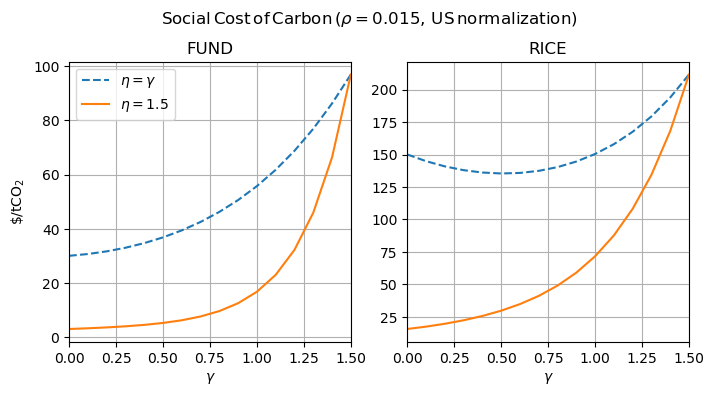

In [24]:
f, axs = subplots(1,2, sharex= true, sharey=false, figsize=(8,4))
f[:subplots_adjust](bottom=0.15)

axs[1][:plot](df_figure1_panelA_line1[:gamma], df_figure1_panelA_line1[:scc], "--")
axs[1][:plot](df_figure1_panelA_line2[:gamma], df_figure1_panelA_line2[:scc])
axs[1][:set_title]("FUND")
axs[1][:legend]([L"$\eta=\gamma$", L"$\eta=1.5$"], loc="upper left")
axs[1][:set_xlim]([0., 1.5])
axs[1][:grid]()
axs[1][:set_xlabel](L"$\gamma$")
axs[1][:set_ylabel](L"$\mathrm{\$/tCO_{2}}$")

axs[2][:plot](df_figure1_panelB_line1[:gamma], df_figure1_panelB_line1[:scc], "--")
axs[2][:plot](df_figure1_panelB_line2[:gamma], df_figure1_panelB_line2[:scc])
axs[2][:set_title]("RICE")
axs[2][:grid]()
axs[2][:set_xlabel](L"$\gamma$")

f[:suptitle](L"\mathrm{Social\/Cost\/of\/Carbon\/(}\rho=0.015,\/\mathrm{US\/normalization)}")

f[:subplots_adjust](top=0.85)

savefig("../output/figure-4-SCC_by_gamma.pdf")
savefig("../output/figure-4-SCC_by_gamma.eps")

nothing

## Figure 5

In [25]:
df_temp = df |> @filter(_.rho==0.015 && _.focusregion==1 && _.gamma==0.7 && _.eta==1.5) |> DataFrame

df_figure2_panelA_line1 = df_temp |> @filter(_.model=="FUND" && _.sigmazero==true) |> DataFrame
df_figure2_panelA_line2 = df_temp |> @filter(_.model=="FUND" && _.sigmazero==false) |> DataFrame
df_figure2_panelA_line3 = df |> @filter(_.rho==0.015 && _.focusregion==1 && _.gamma==0. && _.eta==1.5 && _.model=="FUND" && _.sigmazero==false) |> DataFrame

df_figure2_panelB_line1 = df_temp |> @filter(_.model=="RICE" && _.sigmazero==true) |> DataFrame
df_figure2_panelB_line2 = df_temp |> @filter(_.model=="RICE" && _.sigmazero==false) |> DataFrame
df_figure2_panelB_line3 = df |> @filter(_.rho==0.015 && _.focusregion==1 && _.gamma==0. && _.eta==1.5 && _.model=="RICE" && _.sigmazero==false) |> DataFrame
nothing

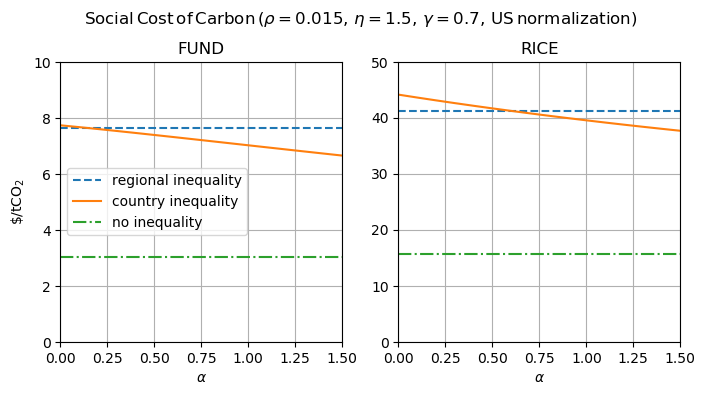

In [26]:
f, axs = subplots(1,2, sharex= true, sharey=false, figsize=(8,4))
f[:subplots_adjust](bottom=0.15)

axs[1][:plot](df_figure2_panelA_line1[:alpha], df_figure2_panelA_line1[:scc], "--")
axs[1][:plot](df_figure2_panelA_line2[:alpha], df_figure2_panelA_line2[:scc])
axs[1][:plot](df_figure2_panelA_line3[:alpha], df_figure2_panelA_line3[:scc], "-.")
axs[1][:set_title]("FUND")
axs[1][:legend](["regional inequality", "country inequality", "no inequality"], loc="center left")
axs[1][:set_xlim]([0., 1.5])
axs[1][:set_ylim]([0., 10])
axs[1][:grid]()
axs[1][:set_xlabel](L"$\alpha$")
axs[1][:set_ylabel](L"$\mathrm{\$/tCO_{2}}$")

axs[2][:plot](df_figure2_panelB_line1[:alpha], df_figure2_panelB_line1[:scc], "--")
axs[2][:plot](df_figure2_panelB_line2[:alpha], df_figure2_panelB_line2[:scc])
axs[2][:plot](df_figure2_panelB_line3[:alpha], df_figure2_panelB_line3[:scc], "-.")
axs[2][:set_title]("RICE")
axs[2][:set_ylim]([0., 50])
axs[2][:grid]()
axs[2][:set_xlabel](L"$\alpha$")

f[:suptitle](L"\mathrm{Social\/Cost\/of\/Carbon\/(}\rho=0.015,\/\eta=1.5,\/\gamma=0.7,\/\mathrm{US\/normalization)}")

f[:subplots_adjust](top=0.85)

PyPlot.savefig("../output/figure-5-SCC_by_alpha.pdf")
PyPlot.savefig("../output/figure-5-SCC_by_alpha.eps")

nothing

## Figure B.1

In [27]:
df_temp = df |> @filter(_.rho==0.015 && _.eta==1.5 && _.sigmazero==true && _.alpha==0. && _.focusregion!=-1) |> DataFrame

df_figure3_panelA_line1 = df_temp |> @filter(_.model=="FUND" && _.gamma==0.0) |> @orderby(_.scc) |> DataFrame
df_figure3_panelA_line2= df_temp |> @filter(_.model=="FUND" && _.gamma==0.1) |> @orderby(_.scc) |> DataFrame
df_figure3_panelA_line3= df_temp |> @filter(_.model=="FUND" && _.gamma==0.3) |> @orderby(_.scc) |> DataFrame
df_figure3_panelA_line4= df_temp |> @filter(_.model=="FUND" && _.gamma==0.5) |> @orderby(_.scc) |> DataFrame
df_figure3_panelA_line5= df_temp |> @filter(_.model=="FUND" && _.gamma==0.7) |> @orderby(_.scc) |> DataFrame
df_figure3_panelB_line1 = df_temp |> @filter(_.model=="RICE" && _.gamma==0.0) |> @orderby(_.scc) |> DataFrame
df_figure3_panelB_line2 = df_temp |> @filter(_.model=="RICE" && _.gamma==0.1) |> @orderby(_.scc) |> DataFrame
df_figure3_panelB_line3 = df_temp |> @filter(_.model=="RICE" && _.gamma==0.3) |> @orderby(_.scc) |> DataFrame
df_figure3_panelB_line4 = df_temp |> @filter(_.model=="RICE" && _.gamma==0.5) |> @orderby(_.scc) |> DataFrame
df_figure3_panelB_line5 = df_temp |> @filter(_.model=="RICE" && _.gamma==0.7) |> @orderby(_.scc) |> DataFrame

nothing

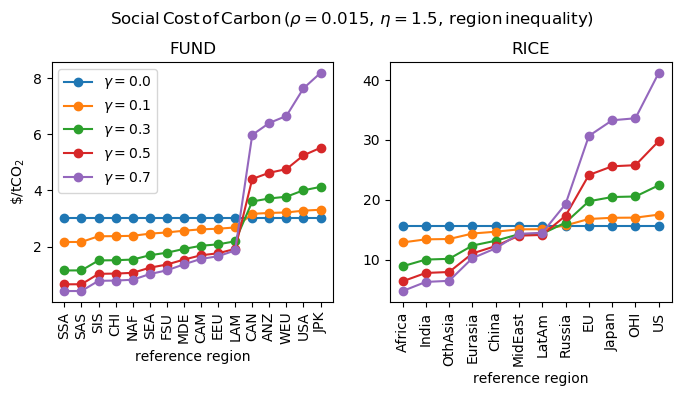

In [28]:
f, axs = subplots(1,2, sharex= false, sharey=false, figsize=(8,4))
f[:subplots_adjust](bottom=0.25)

axs[1][:plot](collect(1:16), df_figure3_panelA_line1[:scc], marker="o")
axs[1][:plot](collect(1:16), df_figure3_panelA_line2[:scc], marker="o")
axs[1][:plot](collect(1:16), df_figure3_panelA_line3[:scc], marker="o")
axs[1][:plot](collect(1:16), df_figure3_panelA_line4[:scc], marker="o")
axs[1][:plot](collect(1:16), df_figure3_panelA_line5[:scc], marker="o")
axs[1][:set_xticks](collect(1:16))
axs[1][:set_xticklabels]([fund_regions[i] for i in df_figure3_panelA_line2[:focusregion]], rotation="vertical", ha="center")
axs[1][:set_title]("FUND")
axs[1][:set_xlabel]("reference region")
axs[1][:set_ylabel](L"$\mathrm{\$/tCO_{2}}$")
axs[1][:legend]([L"\gamma=0.0", L"\gamma=0.1", L"\gamma=0.3", L"\gamma=0.5", L"\gamma=0.7"], loc="upper left")

axs[2][:plot](collect(1:12), df_figure3_panelB_line1[:scc], marker="o")
axs[2][:plot](collect(1:12), df_figure3_panelB_line2[:scc], marker="o")
axs[2][:plot](collect(1:12), df_figure3_panelB_line3[:scc], marker="o")
axs[2][:plot](collect(1:12), df_figure3_panelB_line4[:scc], marker="o")
axs[2][:plot](collect(1:12), df_figure3_panelB_line5[:scc], marker="o")
axs[2][:set_xticks](collect(1:12))
axs[2][:set_xticklabels]([rice_regions[i] for i in df_figure3_panelB_line2[:focusregion]], rotation="vertical", ha="center")
axs[2][:set_title]("RICE")
axs[2][:set_xlabel]("reference region")

f[:suptitle](L"\mathrm{Social\/Cost\/of\/Carbon\/(}\rho=0.015,\/\eta=1.5,\/\mathrm{region\/inequality)}")

f[:subplots_adjust](top=0.85)

PyPlot.savefig("../output/figure-B1-SCC_by_normalization.pdf")
PyPlot.savefig("../output/figure-B1-SCC_by_normalization.eps")

nothing

# Figure 7

In [29]:
df_temp = df |> @filter(_.rho==0.015 && ( (_.focusregion==9 && _.model=="RICE") || (_.focusregion==15 && _.model=="FUND") ) && _.alpha==1. && _.gamma<=1.5) |> DataFrame

df_figure4_panelA_line1 = df_temp |> @filter(_.model=="FUND" && _.sigmazero==true && _.eta==_.gamma) |> DataFrame
df_figure4_panelA_line2 = df_temp |> @filter(_.model=="FUND" && _.sigmazero==true && _.eta==1.5) |> DataFrame

df_figure4_panelB_line1 = df_temp |> @filter(_.model=="RICE" && _.sigmazero==true && _.eta==_.gamma) |> DataFrame
df_figure4_panelB_line2 = df_temp |> @filter(_.model=="RICE" && _.sigmazero==true && _.eta==1.5) |> DataFrame
nothing

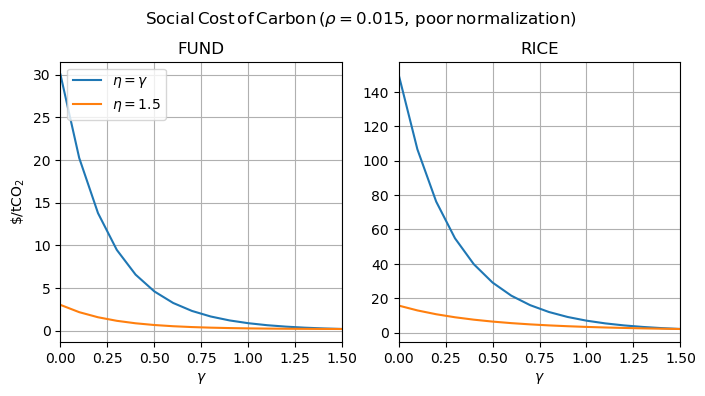

In [30]:
f, axs = subplots(1,2, sharex= true, sharey=false, figsize=(8,4))
f[:subplots_adjust](bottom=0.15)

axs[1][:plot](df_figure4_panelA_line1[:gamma], df_figure4_panelA_line1[:scc])
axs[1][:plot](df_figure4_panelA_line2[:gamma], df_figure4_panelA_line2[:scc])
axs[1][:set_title]("FUND")
axs[1][:legend]([L"$\eta=\gamma$", L"$\eta=1.5$"], loc="upper left")
axs[1][:set_xlim]([0., 1.5])
axs[1][:grid]()
axs[1][:set_xlabel](L"$\gamma$")
axs[1][:set_ylabel](L"$\mathrm{\$/tCO_{2}}$")

axs[2][:plot](df_figure4_panelB_line1[:gamma], df_figure4_panelB_line1[:scc])
axs[2][:plot](df_figure4_panelB_line2[:gamma], df_figure4_panelB_line2[:scc])
axs[2][:set_title]("RICE")
axs[2][:grid]()
axs[2][:set_xlabel](L"$\gamma$")

f[:suptitle](L"\mathrm{Social\/Cost\/of\/Carbon\/(}\rho=0.015,\/\mathrm{poor\/normalization)}")

f[:subplots_adjust](top=0.85)

savefig("../output/figure-B2-SCC_by_gamma_for_poor_normalization.pdf")
savefig("../output/figure-B2-SCC_by_gamma_for_poor_normalization.eps")

nothing

## Table rho sensitivity

gamma = 1.5

In [31]:
df_table3 = df |>
@filter(_.focusregion == 1 && _.alpha == 1. && _.gamma == 1.5 && _.eta == 1.5 && _.sigmazero == true) |>
@map({_.model,_.rho,_.scc}) |> DataFrame
df_table3 = unstack(df_table3, :rho, :model, :scc)
sort!(df_table3, cols=[:rho])
df_table3

,rho,FUND,RICE
1,0.001,501.65744083813934,765.3632410605607
2,0.015,96.98382245660511,211.63834141800507
3,0.03,-0.6477970590671276,95.66957869032149


gamma = 0.7

In [32]:
df_table3 = df |>
@filter(_.focusregion == 1 && _.alpha == 1. && _.gamma == 0.7 && _.eta == 1.5 && _.sigmazero == true) |>
@map({_.model,_.rho,_.scc}) |> DataFrame
df_table3 = unstack(df_table3, :rho, :model, :scc)
sort!(df_table3, cols=[:rho])
df_table3

,rho,FUND,RICE
1,0.001,43.65383967231869,156.93059957991792
2,0.015,7.632867529476206,41.18934090626829
3,0.03,-0.5707378292392571,17.955122078422594


gamma = 0.0

In [33]:
df_table3 = df |>
@filter(_.focusregion == 1 && _.alpha == 1. && _.gamma == 0 && _.eta == 1.5 && _.sigmazero == true) |>
@map({_.model,_.rho,_.scc}) |> DataFrame
df_table3 = unstack(df_table3, :rho, :model, :scc)
sort!(df_table3, cols=[:rho])
df_table3

,rho,FUND,RICE
1,0.001,15.467706080658312,63.05998357043883
2,0.015,3.015233290458761,15.71664082977158
3,0.03,0.33694183484945595,6.594020916886797


## Table central results

In [34]:
df_table4 = DataFrame(Any, 0, 4)
push!(df_table4, ["", "parameter specification", "FUND", "RICE"])
model_base_fund = df |> @filter(_.model=="FUND" && _.rho==0.015 && _.eta==1.5 && _.gamma==0 && _.alpha==1 && _.sigmazero==true && _.focusregion==1) |> @map(get(_.scc)) |> first
model_base_rice = df |> @filter(_.model=="RICE" && _.rho==0.015 && _.eta==1.5 && _.gamma==0 && _.alpha==1 && _.sigmazero==true && _.focusregion==1) |> @map(get(_.scc)) |> first
push!(df_table4, ["model base value", "eta=1.5, rho=0.015", model_base_fund, model_base_rice])
model_ri_fund = df |> @filter(_.model=="FUND" && _.rho==0.015 && _.eta==1.5 && _.gamma==0.7 && _.alpha==1 && _.sigmazero==true && _.focusregion==1) |> @map(get(_.scc)) |> first
model_ri_rice = df |> @filter(_.model=="RICE" && _.rho==0.015 && _.eta==1.5 && _.gamma==0.7 && _.alpha==1 && _.sigmazero==true && _.focusregion==1) |> @map(get(_.scc)) |> first
push!(df_table4, ["disentangled inequality aversion", "and gamma=0.7", model_ri_fund, model_ri_rice])
model_ci_fund = df |> @filter(_.model=="FUND" && _.rho==0.015 && _.eta==1.5 && _.gamma==0.7 && _.alpha==1 && _.sigmazero==false && _.focusregion==1) |> @map(get(_.scc)) |> first
model_ci_rice = df |> @filter(_.model=="RICE" && _.rho==0.015 && _.eta==1.5 && _.gamma==0.7 && _.alpha==1 && _.sigmazero==false && _.focusregion==1) |> @map(get(_.scc)) |> first
push!(df_table4, ["and country inequality", "and alpha=1.0", model_ci_fund, model_ci_rice])
df_table4

,x1,x2,x3,x4
1,,parameter specification,FUND,RICE
2,model base value,"eta=1.5, rho=0.015",3.015233290458761,15.71664082977158
3,disentangled inequality aversion,and gamma=0.7,7.632867529476206,41.18934090626829
4,and country inequality,and alpha=1.0,7.01597828498813,39.53364115105107
